In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import json

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [2]:
submissions = []

with open('submissions_CasualConversation_filtered_with_comment_data.json', 'r') as save_file:
    saved_lines = save_file.readlines()
    for line in saved_lines:
        json_line = json.loads(line)
        submissions.append(json_line)

In [3]:
def split_train_test(submissions,train_set_fraction,randomize=True):
    ''' Function for splitting data in training and test set
    
    =========================== ===============================================
    Attribute                   Description
    =========================== ===============================================
    "data"                      The data that needs to be split up.
    "train_set_fraction"        The fraction of the data that needs to be in 
                                the training set. 
    "randomize"                 Whether the order of the data should be 
                                shuffled.
    =========================== ===============================================
    '''
    data = []
    for submission in submissions:
        text = submission['title'] + '\n' + submission['selftext']
        flair_label = submission['link_flair_text']
        score_label = submission["score"]
        num_comments_label = submission["num_comments"]
        comment_influx = submission['comment_influx']
        comment_text = submission['comment_toplevel_text']
        data.append([[text,comment_influx,comment_text],flair_label, score_label, num_comments_label])
    if(randomize): np.random.shuffle(data)
    trainsize = round(len(data) * train_set_fraction)

    train_set = [entry[0] for entry in data[:trainsize]]
    test_set = [entry[0] for entry in data[trainsize:]]
    
    train_flair_labels = [entry[1] for entry in data[:trainsize]]
    test_flair_labels = [entry[1] for entry in data[trainsize:]]
    
    train_score_labels = [entry[2] for entry in data[:trainsize]]
    test_score_labels = [entry[2] for entry in data[trainsize:]]
    
    train_numcomments_labels = [entry[3] for entry in data[:trainsize]]
    test_numcomments_labels = [entry[3] for entry in data[trainsize:]]
    
    return train_set, test_set, train_flair_labels, test_flair_labels, train_score_labels, test_score_labels, train_numcomments_labels, test_numcomments_labels 

In [4]:
train_x, test_x, train_flair_labels, test_flair_labels, train_score_labels, test_score_labels, train_numcomments_labels,  test_numcomments_labels = split_train_test(submissions,0.8)

In [67]:
# x=np.array(train_x)
# y=np.array(train_y)
x = train_x
y = train_numcomments_labels

In [6]:
# default params
scoring='accuracy'
cv=3
n_jobs=1
max_features = 2500

In [7]:
class Stemmer(BaseEstimator):
    def __init__(self):
        self.l = PorterStemmer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda text:  ' '.join([self.l.stem(word.lower()) for word in text.split()]), x)
        x = np.array(list(x))
        return x

In [8]:
tfidf = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(2, 2), analyzer='word', 
                        stop_words='english')
sm = Stemmer()
lr = LogisticRegression()
p = Pipeline([
    ('sm', sm),
    ('tfidf', tfidf),
    ('lr', lr)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


AttributeError: 'list' object has no attribute 'split'

In [9]:
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lr = LogisticRegression()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('lr', lr)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


AttributeError: 'list' object has no attribute 'split'

In [19]:
p.fit(x,y)

Pipeline(memory=None,
     steps=[('sm', Stemmer()), ('wc_tfidfs', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_w', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2500, min...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
predictions = p.predict(np.array(test_x))

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from plot_confusion_matrix import plot_confusion_matrix


import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
labels = ['Music','Movie and Show', 'Gaming', 'Book', 'Neat']
y_pred = predictions
y_true = np.array(test_y)
print(accuracy_score(y_true, y_pred))
confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, classes=np.array(labels), normalize=True)
# classes=np.array(labels)
# i = classes[unique_labels(y_true, y_pred)]

NameError: name 'predictions' is not defined

In [10]:
from xgboost import XGBClassifier

tfidf = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(2, 2), analyzer='word', 
                        stop_words='english')
sm = Stemmer()
xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('tfidf', tfidf),
    ('xgb', xgb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

ModuleNotFoundError: No module named 'xgboost'

In [9]:
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('xgb', xgb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

NameError: name 'XGBClassifier' is not defined

In [13]:
from lightgbm import LGBMClassifier as lgb

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('lgbm', lgbm)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


AttributeError: 'list' object has no attribute 'split'

In [ ]:
a = """
I don't like playing  MUSIC song music melody alone. It's very eerie. I can't deal with it, it really freaks me out. The dark, long The near-silent forests. The shadows dancing at the edge of my screen.

It doesn't help my current world has a weird pitch where some of the nearby forests are lit up despite the lack of any light sources.

I can never mute alone for long. When I'm with someone this fear all goes away, of course, but I can't play  alone.

Are there any  that weirdly freak you out?"
"""

In [ ]:
p.predict(np.array(["hi this is me as I like dungeons and dragons","What do you guys like watching?",a]))

In [28]:
class ToDense(BaseEstimator):

    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x.toarray()

In [30]:
from sklearn.naive_bayes import GaussianNB

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
gnb = GaussianNB()
td = ToDense()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('td', td),
    ('gnb', gnb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.9s finished


array([0.65993266, 0.67452301, 0.65955056])

In [31]:
from sklearn.naive_bayes import MultinomialNB

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
mnb = MultinomialNB()
td = ToDense()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('td', td),
    ('mnb', mnb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s finished


array([0.76655443, 0.76094276, 0.76404494])

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [16]:
data_train_x ={"submission_text": np.array([x[idx][0] for idx in range(len(x))]),
               "comment_influx": np.array([x[idx][1] for idx in range(len(x))]),
               "comment_text": np.array([x[idx][2] for idx in range(len(x))])} 

In [17]:
d = {"submission_text": np.array([x[idx][0] for idx in range(len(x))]),
               "comment_text": np.array([x[idx][2] for idx in range(len(x))])} 

keys = [i for i in range(24)]

In [18]:
data = pd.concat([pd.DataFrame(d), pd.DataFrame(data_train_x["comment_influx"])], axis=1)

In [19]:
data

,submission_text,comment_text,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,What types of Rock music do you like?\nHi ever...,\n [Stoner rock](https://youtu.be/_o8Qqfu1pwQ...,0,1,3,6,7,9,10,10,...,16,16,16,17,19,19,21,22,22,22
1,Not sure if this is the place to ask but if th...,\n Do you play on ps4? I play a lot of Fortni...,3,3,3,4,4,4,4,4,...,4,4,4,6,6,6,8,12,12,14
2,What's your favourite game console/medium?\nHe...,"\n I really only play on my PS4, but I love g...",1,2,2,3,3,5,5,6,...,13,13,14,16,16,16,16,18,20,21
3,Does anyone here make their own music?\nI love...,"\n I don't do my own music, but one of my Fri...",0,1,4,5,6,8,9,12,...,21,21,21,21,21,22,22,22,22,22
4,No-Skins in Fortnite are honestly the most kin...,\n [deleted] \n I don't understand why people...,1,3,4,5,8,8,8,8,...,9,9,9,9,10,10,10,10,10,10
5,I could do with some suggestions of a gripping...,\n Have you seen Better Call Saul? It's Break...,0,1,2,3,3,4,4,4,...,7,7,7,7,8,8,8,8,9,9
6,It's A Wonderful Soundtrack Christmas! (Specia...,,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,What is your all time top 10 albums?\nSo I've ...,\n In no particular order: \n\n1. Guns N' Ros...,0,0,0,0,0,1,2,3,...,9,9,9,9,9,9,9,9,9,9
8,What movie should I watch and why?\nI want to ...,\n Senna. Awesome documentary about an amazi...,0,1,1,1,1,2,2,3,...,6,6,6,7,8,8,8,8,8,8
9,Just discovered the music from Dear Evan Hanse...,\n Hey fellow Irish person! My younger sister...,0,0,0,1,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [69]:
# With comment influx only
from lightgbm import LGBMClassifier as lgb
sm = Stemmer()
scoring='mean_absolute_error'
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('selector', ItemSelector(key=keys)),
    ('lgbm', lgbm),
         ])

cross_val_score(estimator=p, X=data, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed i

array([-43.87770701, -17.81925926, -17.34872611])

In [63]:
p.fit(X=data, y=y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('subtext', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='submission_text')), ('sm', Stemmer()), ('wc_tfidfs', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_w', TfidfVectorizer(analyzer='word', binary=False...0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [65]:
from sklearn.metrics import mean_absolute_error
y_pred = p.predict(data)
y_true = y
print(mean_absolute_error(y_true, y_pred))

ValueError: Number of features of the model must match the input. Model n_features_ is 5414 and input n_features is 5556 

In [35]:
y_pred

array([   6,    3,   14, ...,    5, 3933,    2])

In [38]:
np.values(y_true)

AttributeError: module 'numpy' has no attribute 'values'

In [28]:
# With submission text and comment influx
from lightgbm import LGBMClassifier as lgb
sm = Stemmer()
scoring='mean_squared_error'
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
     ('union', FeatureUnion(
        transformer_list=[
            ('subtext', Pipeline([
                ('selector', ItemSelector(key='submission_text')),
                ('sm', sm),
                ('wc_tfidfs', 
                     FeatureUnion([
                        ('tfidf_w', tfidf_w), 
                        ('tfidf_c', tfidf_c), 
                     ])
                ),                
            ])),

            ('commentinflux', Pipeline([
                ('selector', ItemSelector(key=keys)),            
            ])),
        ],
                    # weight components in FeatureUnion
            transformer_weights={
                'subtext': 0.5,
                'commentinflux': 1.0,
            },
     )),
    ('lgbm', lgbm),
         ])

cross_val_score(estimator=p, X=data, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in futur

array([0.07673267, 0.08828006, 0.09630819])

In [245]:
# With comment text
from lightgbm import LGBMClassifier as lgb
keys = [i for i in range(24)]+["comment_text"]
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
     ('union', FeatureUnion(
        transformer_list=[
            ('subtext', Pipeline([
                ('selector', ItemSelector(key='submission_text')),
                ('sm', sm),
                ('wc_tfidfs', 
                     FeatureUnion([
                        ('tfidf_w', tfidf_w), 
                        ('tfidf_c', tfidf_c), 
                     ])
                ),                
            ])),

            ('commenttext', Pipeline([
                ('selector', ItemSelector(key='comment_text')),
                ('sm', sm),
                ('wc_tfidfs', 
                     FeatureUnion([
                        ('tfidf_w', tfidf_w), 
                        ('tfidf_c', tfidf_c), 
                     ])
                ),                
            ])),
        ],
                    # weight components in FeatureUnion
#             transformer_weights={
#                 'subtext': 0.0,
#                 'commentinflux': 1.0,
#             },
     )),
    ('lgbm', lgbm),
         ])

cross_val_score(estimator=p, X=data, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


array([0.90961263, 0.90804598, 0.9352518 ])

In [68]:
# With comment influx and text
from lightgbm import LGBMClassifier as lgb
scoring='mean_squared_error'
keys = [i for i in range(24)]
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
     ('union', FeatureUnion(
        transformer_list=[
            ('subtext', Pipeline([
                ('selector', ItemSelector(key='submission_text')),
                ('sm', sm),
                ('wc_tfidfs', 
                     FeatureUnion([
                        ('tfidf_w', tfidf_w), 
                        ('tfidf_c', tfidf_c), 
                     ])
                ),                
            ])),

            ('commenttext', Pipeline([
                ('selector', ItemSelector(key='comment_text')),
                ('sm', sm),
                ('wc_tfidfs', 
                     FeatureUnion([
                        ('tfidf_w', tfidf_w), 
                        ('tfidf_c', tfidf_c), 
                     ])
                ),                
            ])),
            
            ('commentinflux', Pipeline([
                ('selector', ItemSelector(key=keys)),            
            ])),
            
        ],
#                     # weight components in FeatureUnion
#             transformer_weights={
#                 'subtext': 0.5,
#                 'commenttext': 0.5,
#                 'commentinflux': 0.5,
#             },
     )),
    ('lgbm', lgbm),
         ])

cross_val_score(estimator=p, X=data, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


array([-38332.58089172,   -734.53481481,   -578.79617834])

In [31]:
p.get_params()

{'memory': None,
 'steps': [('selector',
   ItemSelector(key=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
  ('lgbm',
   LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=10,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0))],
 'selector': ItemSelector(key=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
 'lgbm': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.1, max_depth=10,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=300, n_jobs=-1, num_lea

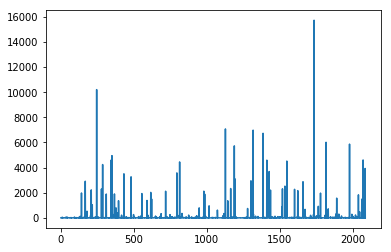

In [44]:
import matplotlib.pyplot as plt
plt.plot(y_true)

In [48]:
y_true_sorted = np.sort(np.copy(y_true))

(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 2., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 3., 1., 2., 1., 0., 0., 2., 1., 2., 2., 2., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([1000., 1040., 1080., 1120., 1160., 1200., 1240., 1280., 1320.,
        1360., 1400., 1440., 1480., 1520., 1560., 1600., 1640., 1680.,
        1720., 1760., 1800., 1840., 1880., 1920., 1960., 2000., 2040.,
        2080., 2120., 2160., 2200., 2240., 2280., 2320., 2360., 2400.,
        2440., 2480., 2520., 2560., 2600., 2640., 2680., 2720., 2760.,
        2800., 2840., 2880., 2920., 2960., 3000., 3040., 3080., 3120.,
        3160., 3200., 3240., 3280., 3320., 3360., 3400., 3440., 3480.,
        3520., 3560., 3600., 3640., 3680., 3720., 376

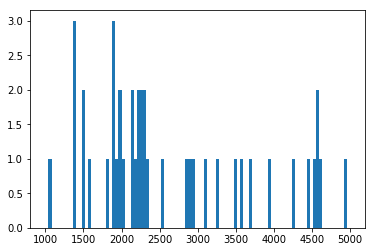

In [61]:
plt.hist(y_true_sorted, bins=100, range=(1000,5000))

(array([476., 562., 356., 221., 129.,  79.,  57.,  37.,  31.,  17.,  21.,
          7.,   9.,   6.,   4.,   7.,   6.,  10.,   6.,   3.,   3.,   3.,
          1.,   2.,   1.,   2.,   3.,   3.,   2.,   0.,   1.,   4.,   0.,
          2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,
          1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.

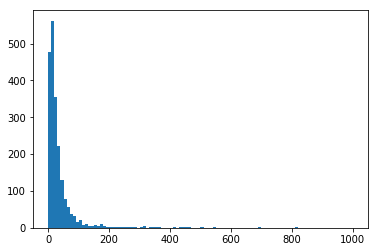

In [71]:
plt.hist(y, bins=100, range=(0,1000))

In [73]:
, bins=100, range=(1000,5000)

AttributeError: 'list' object has no attribute 'std'